Shared folder containg dataset and pretrained models:
https://drive.google.com/drive/folders/1p6fW1tKAfFyyrHcIlJL1ONlhRRnmDFr_?usp=sharing

# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install sentencepiece transformers nlp datasets tensorflow-text tf-models-official bert-extractive-summarizer spacy

     |████████████████████████████████| 1.2 MB 4.3 MB/s 
     |████████████████████████████████| 3.4 MB 33.2 MB/s 
     |████████████████████████████████| 1.7 MB 41.2 MB/s 
     |████████████████████████████████| 306 kB 51.2 MB/s 
     |████████████████████████████████| 4.9 MB 39.2 MB/s 
     |████████████████████████████████| 1.8 MB 45.9 MB/s 
     |████████████████████████████████| 61 kB 552 kB/s 
     |████████████████████████████████| 596 kB 50.3 MB/s 
     |████████████████████████████████| 895 kB 52.5 MB/s 
     |████████████████████████████████| 3.3 MB 31.3 MB/s 
     |████████████████████████████████| 243 kB 54.0 MB/s 
     |████████████████████████████████| 132 kB 46.5 MB/s 
     |████████████████████████████████| 1.1 MB 50.3 MB/s 
     |████████████████████████████████| 90 kB 9.4 MB/s 
     |████████████████████████████████| 213 kB 47.4 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 352 kB 48.8 MB/s 
     |███████████████

# Import

In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import json 

from summarizer import Summarizer, TransformerSummarizer
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer, AutoModelWithLMHead, T5Tokenizer, T5ForConditionalGeneration, T5Config

tf.get_logger().setLevel('ERROR')

# [DON'T RUN] Create datasets [RUN ONLY FIRST TIME]

In [ ]:
! cp /content/drive/MyDrive/imdb/toscan/dataset/dataset.csv .

In [ ]:
df = pd.read_csv('dataset.csv', sep='\t')

In [ ]:
fullDF = df.loc[df['label'] != -1].sample(frac=1) # shuffle
unsupDF = df.loc[df['label'] == -1]

trainDF = fullDF.sample(frac=0.7, axis=0)
valDF = fullDF.drop(index=trainDF.index)

testDF = valDF.sample(frac=0.5, axis=0)
valDF = valDF.drop(index=testDF.index)

In [ ]:
unsupDF.to_csv("unsup.csv", sep="\t")
trainDF.to_csv("train.csv", sep="\t")
valDF.to_csv("val.csv", sep="\t")
testDF.to_csv("test.csv", sep="\t")

Uncomment to overide dataset

In [ ]:
# ! cp unsup.csv /content/drive/MyDrive/imdb/toscan/dataset/unsup.csv
# ! cp train.csv /content/drive/MyDrive/imdb/toscan/dataset/train.csv
# ! cp val.csv /content/drive/MyDrive/imdb/toscan/dataset/val.csv
# ! cp test.csv /content/drive/MyDrive/imdb/toscan/dataset/test.csv

# Load dataset

In [4]:
! cp /content/drive/MyDrive/imdb/toscan/dataset/dataset.csv .
! cp /content/drive/MyDrive/imdb/toscan/dataset/unsup.csv .
! cp /content/drive/MyDrive/imdb/toscan/dataset/train.csv .
! cp /content/drive/MyDrive/imdb/toscan/dataset/val.csv .
! cp /content/drive/MyDrive/imdb/toscan/dataset/test.csv .

In [5]:
df = pd.read_csv('dataset.csv', sep='\t')
unsupDF = pd.read_csv('unsup.csv', sep='\t')
trainDF = pd.read_csv('train.csv', sep='\t')
valDF = pd.read_csv('val.csv', sep='\t')
testDF = pd.read_csv('test.csv', sep='\t')

In [6]:
def datasetFromDf(df, batch_size=32, shuffle=True, forRegression=False):
  ds = tf.data.Dataset.from_tensor_slices((df['review'], df['rating'] / 10 if forRegression else df['label']))
  if shuffle:
    ds = ds.shuffle(len(df), reshuffle_each_iteration=True)
  return ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
train = datasetFromDf(trainDF)
val = datasetFromDf(valDF)
test = datasetFromDf(testDF)

In [8]:
train_reg = datasetFromDf(trainDF, forRegression=True)
val_reg = datasetFromDf(valDF, forRegression=True)
test_reg = datasetFromDf(testDF, forRegression=True)

In [9]:
# full = datasetFromDf(df.loc[df['label'] != -1])
# full = datasetFromDf(df.loc[df['label'] != -1], forRegression=True)
# 
# LEN_DATASET = len(full)
# train_size = int(LEN_DATASET * 0.7)
# val_size = int(LEN_DATASET * 0.15)
# test_size = int(LEN_DATASET * 0.15)
# 
# train = full.take(train_size)
# val = full.skip(train_size).take(val_size)
# test = full.skip(train_size + val_size).take(test_size)

print(len(train))
print(len(val))
print(len(test))

1094
235
235


# Load model

In [ ]:
bert_model_name = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
preprocessor_name = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
def getModel():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preprocessor_name, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(bert_model_name, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

def getOptimizer(epochs = 10):
  num_train_steps = tf.data.experimental.cardinality(train).numpy() * epochs
  num_warmup_steps = int(0.1 * num_train_steps)
  return optimization.create_optimizer(
      init_lr=3e-5,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw'
  )

# Regression & Binary

In [ ]:
model = getModel()

In [ ]:
epochs = 10
loss = tf.keras.losses.MeanSquaredError()
metrics = tf.keras.metrics.MeanSquaredError(name="mean_squared_error", dtype=None)
optimizer = getOptimizer(epochs=epochs)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history_reg = model.fit(x=train_reg, validation_data=val_reg, epochs=epochs)

Epoch 1/10
1094/1094 [==============================] - 532s 478ms/step - loss: 0.1690 - mean_squared_error: 0.1690 - val_loss: 0.0637 - val_mean_squared_error: 0.0637
Epoch 2/10
1094/1094 [==============================] - 525s 480ms/step - loss: 0.0773 - mean_squared_error: 0.0773 - val_loss: 0.0770 - val_mean_squared_error: 0.0770
Epoch 3/10
1094/1094 [==============================] - 524s 479ms/step - loss: 0.0531 - mean_squared_error: 0.0531 - val_loss: 0.0453 - val_mean_squared_error: 0.0453
Epoch 4/10
1094/1094 [==============================] - 525s 480ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.0442 - val_mean_squared_error: 0.0442
Epoch 5/10
1094/1094 [==============================] - 525s 480ms/step - loss: 0.0345 - mean_squared_error: 0.0345 - val_loss: 0.0446 - val_mean_squared_error: 0.0446
Epoch 6/10
1094/1094 [==============================] - 524s 479ms/step - loss: 0.0281 - mean_squared_error: 0.0281 - val_loss: 0.0446 - val_mean_squared_error:

In [ ]:
loss_reg, _ = model.evaluate(test_reg)
print(f'Loss: {loss_reg}')

235/235 [==============================] - 51s 218ms/step - loss: 0.0434 - mean_squared_error: 0.0434
Loss: 0.043350521475076675


In [ ]:
model.save('./model-reg')

In [ ]:
! zip -r model-reg.zip model-reg
! cp model-reg.zip drive/MyDrive/imdb/toscan/model-reg.zip

  adding: model-reg/ (stored 0%)
  adding: model-reg/variables/ (stored 0%)
  adding: model-reg/variables/variables.index (deflated 79%)
  adding: model-reg/variables/variables.data-00000-of-00001 (deflated 15%)
  adding: model-reg/assets/ (stored 0%)
  adding: model-reg/assets/vocab.txt (deflated 53%)
  adding: model-reg/keras_metadata.pb (deflated 83%)
  adding: model-reg/saved_model.pb (deflated 92%)


In [ ]:
epochs = 10
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
optimizer = getOptimizer(epochs=epochs)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history_regbin = model.fit(x=train, validation_data=val, epochs=epochs)

Epoch 1/10
1094/1094 [==============================] - 530s 479ms/step - loss: 0.1920 - binary_accuracy: 0.9511 - val_loss: 0.4145 - val_binary_accuracy: 0.8628
Epoch 2/10
1094/1094 [==============================] - 522s 477ms/step - loss: 0.1256 - binary_accuracy: 0.9575 - val_loss: 0.7086 - val_binary_accuracy: 0.8579
Epoch 3/10
1094/1094 [==============================] - 523s 478ms/step - loss: 0.1007 - binary_accuracy: 0.9695 - val_loss: 0.6787 - val_binary_accuracy: 0.8561
Epoch 4/10
1094/1094 [==============================] - 511s 467ms/step - loss: 0.0748 - binary_accuracy: 0.9793 - val_loss: 0.7418 - val_binary_accuracy: 0.8576
Epoch 5/10
1094/1094 [==============================] - 510s 466ms/step - loss: 0.0569 - binary_accuracy: 0.9850 - val_loss: 0.7938 - val_binary_accuracy: 0.8624
Epoch 6/10
1094/1094 [==============================] - 509s 465ms/step - loss: 0.0393 - binary_accuracy: 0.9904 - val_loss: 0.9265 - val_binary_accuracy: 0.8591
Epoch 7/10
1094/1094 [======

In [ ]:
loss_regbin, accuracy_regbin = model.evaluate(test)
print(f'Loss: {loss_regbin}')
print(f'Accuracy: {accuracy_regbin}')

235/235 [==============================] - 49s 209ms/step - loss: 1.1243 - binary_accuracy: 0.8643
Loss: 1.1243016719818115
Accuracy: 0.8642666935920715


In [ ]:
model.save('./model-regbin')

In [ ]:
! zip -r model-regbin.zip model-regbin
! cp model-regbin.zip drive/MyDrive/imdb/toscan/model-regbin.zip

  adding: model-regbin/ (stored 0%)
  adding: model-regbin/variables/ (stored 0%)
  adding: model-regbin/variables/variables.index (deflated 79%)
  adding: model-regbin/variables/variables.data-00000-of-00001 (deflated 14%)
  adding: model-regbin/assets/ (stored 0%)
  adding: model-regbin/assets/vocab.txt (deflated 53%)
  adding: model-regbin/keras_metadata.pb (deflated 83%)
  adding: model-regbin/saved_model.pb (deflated 92%)


# Binary & regression

In [ ]:
model = getModel()

In [ ]:
epochs = 10
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
optimizer = getOptimizer(epochs=epochs)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history_bin = model.fit(x=train, validation_data=val, epochs=epochs)

Epoch 1/10
1094/1094 [==============================] - 518s 467ms/step - loss: 0.4848 - binary_accuracy: 0.7412 - val_loss: 0.3569 - val_binary_accuracy: 0.8376
Epoch 2/10
1094/1094 [==============================] - 510s 466ms/step - loss: 0.3292 - binary_accuracy: 0.8509 - val_loss: 0.3244 - val_binary_accuracy: 0.8605
Epoch 3/10
1094/1094 [==============================] - 507s 463ms/step - loss: 0.2468 - binary_accuracy: 0.8985 - val_loss: 0.3788 - val_binary_accuracy: 0.8613
Epoch 4/10
1094/1094 [==============================] - 505s 462ms/step - loss: 0.1824 - binary_accuracy: 0.9305 - val_loss: 0.4480 - val_binary_accuracy: 0.8637
Epoch 5/10
1094/1094 [==============================] - 505s 462ms/step - loss: 0.1411 - binary_accuracy: 0.9498 - val_loss: 0.5034 - val_binary_accuracy: 0.8599
Epoch 6/10
1094/1094 [==============================] - 505s 461ms/step - loss: 0.1058 - binary_accuracy: 0.9653 - val_loss: 0.6459 - val_binary_accuracy: 0.8619
Epoch 7/10
1094/1094 [======

In [ ]:
loss_bin, accuracy_bin = model.evaluate(test)
print(f'Loss: {loss_bin}')
print(f'Accuracy: {accuracy_bin}')

235/235 [==============================] - 49s 210ms/step - loss: 0.7598 - binary_accuracy: 0.8668
Loss: 0.7598153352737427
Accuracy: 0.8668000102043152


In [ ]:
model.save('./model-bin')

In [ ]:
! zip -r model-bin.zip model-bin
! cp model-bin.zip drive/MyDrive/imdb/toscan/model-bin.zip

  adding: model-bin/ (stored 0%)
  adding: model-bin/variables/ (stored 0%)
  adding: model-bin/variables/variables.index (deflated 79%)
  adding: model-bin/variables/variables.data-00000-of-00001 (deflated 15%)
  adding: model-bin/assets/ (stored 0%)
  adding: model-bin/assets/vocab.txt (deflated 53%)
  adding: model-bin/keras_metadata.pb (deflated 83%)
  adding: model-bin/saved_model.pb (deflated 92%)


In [ ]:
epochs = 10
loss = tf.keras.losses.MeanSquaredError()
metrics = tf.keras.metrics.MeanSquaredError(name="mean_squared_error", dtype=None)
optimizer = getOptimizer(epochs=epochs)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history_binreg = model.fit(x=train_reg, validation_data=val_reg, epochs=epochs)

Epoch 1/10
1094/1094 [==============================] - 508s 455ms/step - loss: 5.0036 - mean_squared_error: 5.0036 - val_loss: 0.0594 - val_mean_squared_error: 0.0594
Epoch 2/10
1094/1094 [==============================] - 497s 455ms/step - loss: 0.0582 - mean_squared_error: 0.0582 - val_loss: 0.0490 - val_mean_squared_error: 0.0490
Epoch 3/10
1094/1094 [==============================] - 498s 456ms/step - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0494 - val_mean_squared_error: 0.0494
Epoch 4/10
1094/1094 [==============================] - 501s 458ms/step - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0474 - val_mean_squared_error: 0.0474
Epoch 5/10
1094/1094 [==============================] - 502s 459ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.0487 - val_mean_squared_error: 0.0487
Epoch 6/10
1094/1094 [==============================] - 501s 458ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0474 - val_mean_squared_error:

In [ ]:
loss_binreg, _ = model.evaluate(test_reg)
print(f'Loss: {loss_binreg}')

235/235 [==============================] - 49s 207ms/step - loss: 0.0448 - mean_squared_error: 0.0448
Loss: 0.04477933049201965


In [ ]:
model.save('./model-binreg')

In [ ]:
! zip -r model-binreg.zip model-binreg
! cp model-binreg.zip drive/MyDrive/imdb/toscan/model-binreg.zip

  adding: model-binreg/ (stored 0%)
  adding: model-binreg/variables/ (stored 0%)
  adding: model-binreg/variables/variables.index (deflated 79%)
  adding: model-binreg/variables/variables.data-00000-of-00001 (deflated 15%)
  adding: model-binreg/assets/ (stored 0%)
  adding: model-binreg/assets/vocab.txt (deflated 53%)
  adding: model-binreg/keras_metadata.pb (deflated 83%)
  adding: model-binreg/saved_model.pb (deflated 92%)


# Test all

In [ ]:
! cp -v drive/MyDrive/imdb/toscan/model-*.zip .
! unzip model-reg.zip
! unzip model-regbin.zip
! unzip model-bin.zip
! unzip model-binreg.zip

'drive/MyDrive/imdb/toscan/model-binreg.zip' -> './model-binreg.zip'
'drive/MyDrive/imdb/toscan/model-bin.zip' -> './model-bin.zip'
'drive/MyDrive/imdb/toscan/model-regbin.zip' -> './model-regbin.zip'
'drive/MyDrive/imdb/toscan/model-reg.zip' -> './model-reg.zip'
Archive:  model-reg.zip
   creating: model-reg/
   creating: model-reg/variables/
  inflating: model-reg/variables/variables.index  
  inflating: model-reg/variables/variables.data-00000-of-00001  
   creating: model-reg/assets/
  inflating: model-reg/assets/vocab.txt  
  inflating: model-reg/keras_metadata.pb  
  inflating: model-reg/saved_model.pb  
Archive:  model-regbin.zip
   creating: model-regbin/
   creating: model-regbin/variables/
  inflating: model-regbin/variables/variables.index  
  inflating: model-regbin/variables/variables.data-00000-of-00001  
   creating: model-regbin/assets/
  inflating: model-regbin/assets/vocab.txt  
  inflating: model-regbin/keras_metadata.pb  
  inflating: model-regbin/saved_model.pb  
A

In [ ]:
def evalModel(path):
  model = tf.keras.models.load_model(path, compile=False)
  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  metrics = tf.metrics.BinaryAccuracy()
  model.compile(loss=loss, metrics=metrics)

  loss, acc = model.evaluate(test)
  print(f'Loss: {loss}')
  print(f'Accuracy: {acc}')

In [ ]:
evalModel('./model-reg')

235/235 [==============================] - 56s 228ms/step - loss: 0.6225 - binary_accuracy: 0.8653
Loss: 0.6225188970565796
Accuracy: 0.8653333187103271


In [ ]:
evalModel('./model-bin')

235/235 [==============================] - 54s 228ms/step - loss: 0.7598 - binary_accuracy: 0.8668
Loss: 0.759815514087677
Accuracy: 0.8668000102043152


In [ ]:
evalModel('./model-regbin')

235/235 [==============================] - 54s 228ms/step - loss: 1.1243 - binary_accuracy: 0.8643
Loss: 1.124301791191101
Accuracy: 0.8642666935920715


In [ ]:
evalModel('./model-binreg')

235/235 [==============================] - 54s 229ms/step - loss: 0.6174 - binary_accuracy: 0.8664
Loss: 0.6173639893531799
Accuracy: 0.8664000034332275


# Stuff

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


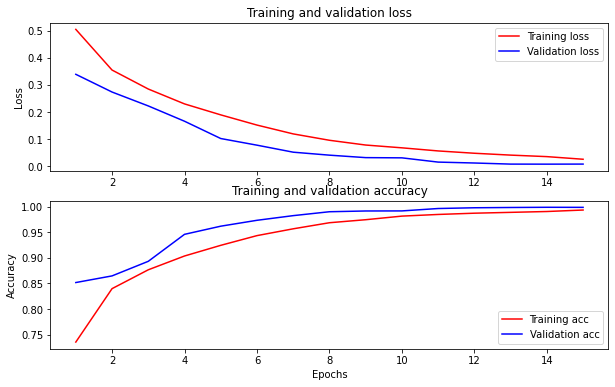

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}' for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

results = tf.sigmoid(model(tf.constant(examples)))

print('Results:')
print_my_examples(examples, results)

Results:
input: this is such an amazing movie! : score: 0.998199
input: The movie was great!           : score: 0.993519
input: The movie was meh.             : score: 0.676415
input: The movie was okish.           : score: 0.000246
input: The movie was terrible...      : score: 0.000174



# Classify unsup

In [ ]:
model = tf.keras.models.load_model('./model-binreg', compile=False)

In [ ]:
reviews = tf.constant(unsupDF['review'])

In [ ]:
predictions = []
n = 50
for i in tqdm(range(len(reviews) // n)):
  start = i*n
  end = start + n
  y = model(reviews[start:end])
  # predictions += list(map(lambda a: 1 if a else 0, (y > 0.5)[:,0].numpy().tolist()))
  predictions += y[:,0].numpy().tolist()

100%|██████████| 1000/1000 [06:05<00:00,  2.74it/s]


In [ ]:
predDF = unsupDF.copy()
predDF['pred'] = predictions
predDF.to_csv("pred.csv", sep="\t")

In [ ]:
! cp pred.csv /content/drive/MyDrive/imdb/toscan/dataset/pred.csv

# Summary

In [10]:
max_length_summary=200

In [11]:
! cp /content/drive/MyDrive/imdb/toscan/dataset/pred.csv .

In [12]:
predDF = pd.read_csv('pred.csv', sep='\t')

In [13]:
predDF['url'].value_counts().head(10)

tt0406728    30
tt0030418    30
tt0144117    30
tt0120112    30
tt0307213    30
tt0036376    30
tt0325596    30
tt0203940    30
tt0253556    30
tt0239986    30
Name: url, dtype: int64

In [14]:
url = 'tt0209163'
predDF.loc[predDF['url'] == url].shape[0]

6

In [15]:
def getReviews(url, reg=False):
  lines = predDF.loc[predDF['url'] == url]
  pos = lines.loc[lines['pred'] >= 0.65]['review'].tolist()
  neg = lines.loc[lines['pred'] < 0.65]['review'].tolist()
  return '\n'.join(pos), '\n'.join(neg)

def printRes(sumPos, sumNeg):
  print(f"- POSITIVE:\n{sumPos}\n")
  print(f"- NEGATIVE:\n{sumNeg}\n")

In [16]:
getReviews(url)

('Even if the stars do a great job, the action is definitely the biggest star in this film, as in the others in the series, and therefore the story has it faults. But if you go for a rollercoaster ride, do you expect subtlety? I hope not, and with that in mind, a lot can be forgiven in this kind of movie, but some things just plain bug me. Like how ** SPOILER WARNING** Anck-su-namun would leave her beloved because she is afraid of a little raining stone! This girl killed a god (or at least a man perceived as one) for Imhotep, and she has already been brought back to life, still she freezes in fear while our brave (and beautiful) Rachel Weizs races to the rescue. **SPOILER END** And most times we are going directly from the one big action scene to the other, without any pause or development of plot. Mostly because of the lack of it. Still, the film could be really good for what it is attempting, cut the brakes and full gas and all that stuff, but then at least they should have gotten th

## BERT

In [17]:
def getSummaries(model, url):
  pos, neg = getReviews(url)
  sumPos = ''.join(model(pos, min_length=60, max_length=max_length_summary))
  sumNeg = ''.join(model(neg, min_length=60, max_length=max_length_summary))
  printRes(sumPos, sumNeg)

In [18]:
sumModel = Summarizer()

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [19]:
getSummaries(sumModel, url)

- POSITIVE:
Even if the stars do a great job, the action is definitely the biggest star in this film, as in the others in the series, and therefore the story has it faults. SPOILER END** And most times we are going directly from the one big action scene to the other, without any pause or development of plot.

- NEGATIVE:
This film is similar to Jurassic Park II, in that the computer graphics make the movie. But only those with the highest tolerance for letting go and enjoying the wild, stupid rile will enjoy it. And annoying, which lowered my vote from an 8 to 4.<br /><br />The DVD-release of the movie is not better. This lowered my vote from 4 to 3.<br /><br />Conclusion: Avoid this movie. Chaos ensues throughout.<br /><br />If you aren't paying attention in this movie, or you miss the first ten minutes, you will be extremely confused. Heck, you could be paying attention the whole movie and still be confused. So much is going on, and so many special effects and new plot lines are shov

In [20]:
sumModel = TransformerSummarizer(transformer_type="GPT2",transformer_model_key="gpt2-medium")

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [21]:
getSummaries(sumModel, url)

- POSITIVE:
Even if the stars do a great job, the action is definitely the biggest star in this film, as in the others in the series, and therefore the story has it faults. I hope not, and with that in mind, a lot can be forgiven in this kind of movie, but some things just plain bug me.

- NEGATIVE:
This film is similar to Jurassic Park II, in that the computer graphics make the movie. If you're thrilled by amusing one liners and nonstop special effects of all kinds of weird creatures, then you're sure to enjoy this second Mummy picture. Jonathan (John Hannah) provides many of the movies cringe worthy lines. It's full of effects that add up to nothing, and characters that do the same. This adds to the idea that it was just a poorly written movie to cash in on the first movie's success. Besides the poor CGI, the action sequences really are quite well done. If you can snag it cheap, you'll feel like you got your money's worth. Sure it had a kid in it, but I didn't think he'd weigh the fi

In [22]:
sumModel = TransformerSummarizer(transformer_type="XLNet",transformer_model_key="xlnet-base-cased")

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

In [23]:
getSummaries(sumModel, url)

- POSITIVE:
Even if the stars do a great job, the action is definitely the biggest star in this film, as in the others in the series, and therefore the story has it faults. Like how ** SPOILER WARNING** Anck-su-namun would leave her beloved because she is afraid of a little raining stone!

- NEGATIVE:
This film is similar to Jurassic Park II, in that the computer graphics make the movie. I loved the first movie so I thought the second one would be even better. The first Mummy picture was quite good, in that it managed to fit in characters and plot amongst the big budget special effects. Heck, you could be paying attention the whole movie and still be confused. There is some entertainment to be found, but you may find after you finish this, you'll be in desperate need for something intelligent.<br /><br />My rating: * 1/2 out of ****. Most of the characters do a lot of traveling and then have a showdown. Mixed in is some chumming of the good guys that leads no where. This adds to the id

## T5

In [24]:
pos, neg = getReviews(url)

### T5 base

In [25]:
model = TFAutoModelForSeq2SeqLM.from_pretrained("t5-base")
tokenizer = AutoTokenizer.from_pretrained("t5-base")

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

In [26]:
def summarize(text):
  inputs = tokenizer(f"summarize: {text}", return_tensors="tf", max_length=512)
  outputs = model.generate(inputs["input_ids"], max_length=max_length_summary, min_length=60, length_penalty=2.0, num_beams=4, early_stopping=True)
  return tokenizer.decode(outputs[0])
sumPos = summarize(pos)
sumNeg = summarize(neg)
printRes(sumPos, sumNeg)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


- POSITIVE:
<pad> the action is definitely the biggest star in this film, as in the others in the series. the film could be really good for what it is trying, cut the brakes and full gas. but at least they should have gotten the special effects right so the scorpion king didn<unk>t look like a plastic doll.

- NEGATIVE:
<pad> "The Mummy Returns" is a campy film that doesn't take itself too seriously. the film is similar to Jurassic Park II in that the computer graphics make the movie. the worst part of the movie is all the animations. the movie is not better.



### wikihow-t5-small

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
name = "deep-learning-analytics/wikihow-t5-small"
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelWithLMHead.from_pretrained(name).to(device)

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/736 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:787: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

In [29]:
def summarize(text):
  inputs = tokenizer.encode(text, return_tensors="pt").to(device)
  summary_ids = model.generate(inputs, max_length=max_length_summary, num_beams=2, repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)
  return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

sumPos = summarize(pos)
sumNeg = summarize(neg)
printRes(sumPos, sumNeg)


Token indices sequence length is longer than the specified maximum sequence length for this model (3404 > 512). Running this sequence through the model will result in indexing errors


- POSITIVE:
Be aware that the action is a big part of the movie, and it is not just a film.Be aware that there are many things that can be forgiven in this movie.Ask yourself why you want to go for a rollercoaster ride.

- NEGATIVE:
Know that this movie is a good movie, but it's not the first one.Know that this movie isn't an action movie.Learn about the characters in the movie.Learn about the plot.Learn about the film.



### T5ForConditionalGeneration

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = T5ForConditionalGeneration.from_pretrained('t5-small').to(device)
tokenizer = T5Tokenizer.from_pretrained('t5-small')

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

In [31]:
def summarize(text):
  text = text.strip().replace("\n","")
  inputs = tokenizer.encode(f"summarize: {text}", return_tensors="pt").to(device)
  summary_ids = model.generate(inputs, num_beams=4, no_repeat_ngram_size=3, min_length=60, max_length=max_length_summary, early_stopping=True)
  return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

sumPos = summarize(pos)
sumNeg = summarize(neg)
printRes(sumPos, sumNeg)

Token indices sequence length is longer than the specified maximum sequence length for this model (3406 > 512). Running this sequence through the model will result in indexing errors


- POSITIVE:
the action is definitely the biggest star in this film, as in the others in the series. but some things just plain bug me in this kind of movie. if you go for a rollercoaster ride, do you expect subtlety? I hope not, and with that in mind, a lot can be forgiven.

- NEGATIVE:
if you're an action movie lover like me, you'll be tempted to try this movie. the movie is a big, soulless, hollywood, summer movie, but it doesn't mesh with the first one. it's not a movie that's a lot of fun, but a good movie, too.

